In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import sys 

%matplotlib inline

In [2]:
sys.path.append(os.path.abspath('../src/data'))

try:
    import bsautils as utils 
except ImportError as e:
    print(f'Trouble: {e}')

In [3]:
# Custom package, has to be install locally from 
# the repo source.
from kdtree import node, build

In [4]:
data_dir = '/Users/davidriser/data/kaon'
data = pd.read_csv(f'{data_dir}/kaon.csv.gzip', compression='gzip', nrows=None)

In [5]:
filters = utils.build_filter(data)
filters.append('helicity != 0')

In [6]:
data = utils.build_dataframe(data, filters)

In [7]:
data.groupby('sector').aggregate({'meson_id':'count'})

,meson_id
sector,
1,213799
2,226505
3,198513
4,192757
5,197880
6,190317


# Compare Two Sectors Using KD-Tree
We're going to start experimenting with this method by comparing two sectors (1 and 2).  I'll first create a local dataset of the combined data with labels, and then build the tree.

In [8]:
data_axes = ['x', 'q2', 'z', 'pt']
aux_data_axes = ['sector']

root = node.Node(
    data=data[data['sector'] < 3][data_axes].values, 
    aux_data=data[data['sector'] < 3][aux_data_axes].values
)

In [9]:
nodes = build.build(root=root, leafsize=10000)

In [10]:
print(f'Tree contains {len(nodes)} nodes')

Tree contains 64 nodes


In [11]:
from scipy.stats import binom_test

In [12]:
# we're going to assign a score to every node
scores = np.zeros(len(nodes))

In [13]:
# the fraction of events which come from sector 1/2
s1 = float(len(data[data['sector'] == 1])) 
s2 = float(len(data[data['sector'] == 2]))
tot = s1 + s2
f1 = s1 / tot 
f2 = s2 / tot

print(f'Tot: {tot}, Sectors: {s1, s2}, Fractions: {f1,f2}')

Tot: 440304.0, Sectors: (213799.0, 226505.0), Fractions: (0.4855713325338857, 0.5144286674661144)


In [14]:
for i, inode in enumerate(nodes):
    npoints = len(inode.aux_data)
    nsector1 = len(np.where(inode.aux_data == 1)[0])
    scores[i] = binom_test(x=nsector1, n=npoints, p=f1)

In [15]:
def get_k_worst_nodes(nodes, scores, k=3):

    if len(nodes) < k:
        raise ValueError('Nodes must be longer then the k-value')

    order = np.argsort(scores)[:k]
    return [nodes[i] for i in order]

def get_k_best_nodes(nodes, scores, k=3):

    if len(nodes) < k:
        raise ValueError('Nodes must be longer then the k-value')

    order = np.argsort(scores)[::-1][:k]
    return [nodes[i] for i in order]

def plot_k_best_nodes(nodes, scores, k=1):

    best_nodes = get_k_best_nodes(nodes, scores, k)
    dim = nodes[0].data.shape[1]

    fig, axes = plt.subplots(nrows=k, ncols=dim, figsize=(dim*4, k*3))

    for i in range(k):
        node = best_nodes[i]
        for j in range(dim):
            idx1 = np.where(node.aux_data == 1)[0]
            idx2 = np.where(node.aux_data == 2)[0]
            axes[i,j].hist(node.data[idx1,j], bins=np.linspace(node.bounds[0,j], node.bounds[1,j], 20), alpha=0.6, edgecolor='k')
            axes[i,j].hist(node.data[idx2,j], bins=np.linspace(node.bounds[0,j], node.bounds[1,j], 20), alpha=0.6, edgecolor='k')
            axes[i,j].grid(alpha=0.2)

    fig.tight_layout()
    return fig, axes

def plot_k_worst_nodes(nodes, scores, k=1):

    worst_nodes = get_k_worst_nodes(nodes, scores, k)
    dim = nodes[0].data.shape[1]

    fig, axes = plt.subplots(nrows=k, ncols=dim, figsize=(dim*4, k*3))

    for i in range(k):
        node = worst_nodes[i]
        for j in range(dim):
            idx1 = np.where(node.aux_data == 1)[0]
            idx2 = np.where(node.aux_data == 2)[0]
            axes[i,j].hist(node.data[idx1,j], bins=np.linspace(node.bounds[0,j], node.bounds[1,j], 20), alpha=0.6, edgecolor='k')
            axes[i,j].hist(node.data[idx2,j], bins=np.linspace(node.bounds[0,j], node.bounds[1,j], 20), alpha=0.6, edgecolor='k')
            axes[i,j].grid(alpha=0.2)

    fig.tight_layout()
    return fig, axes

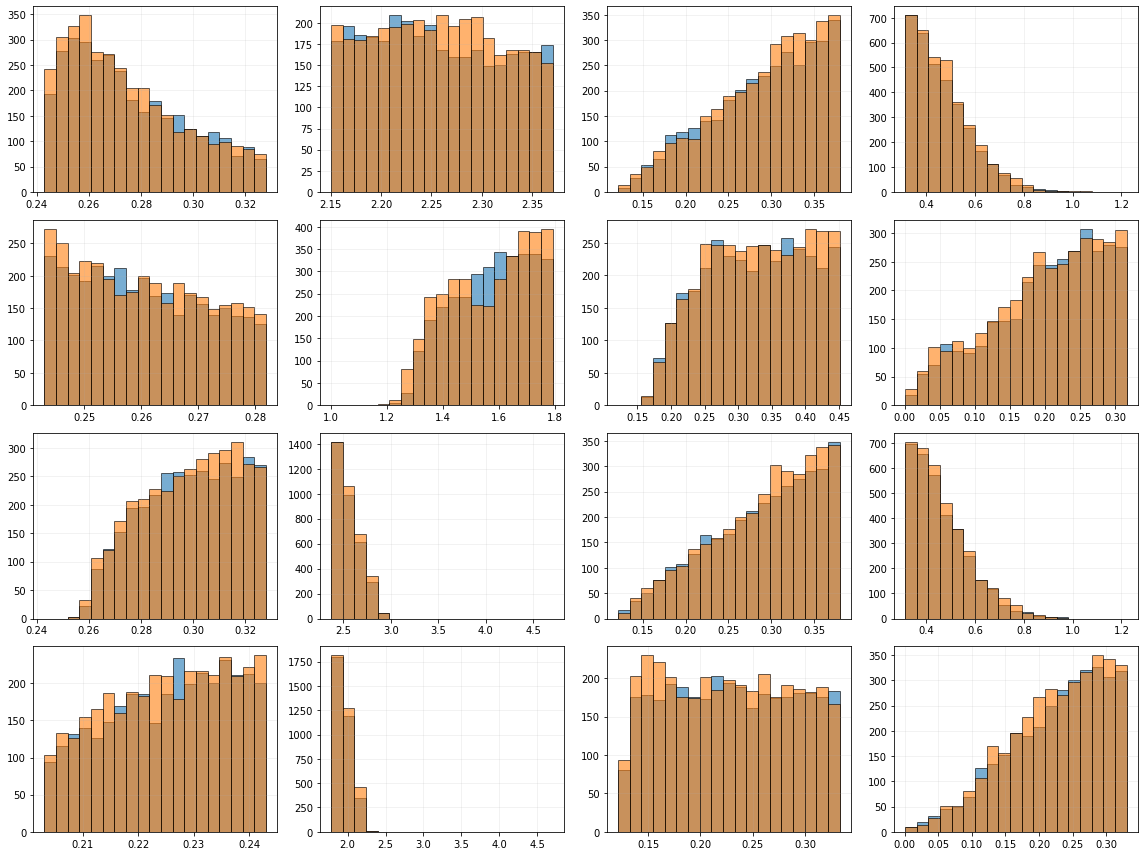

In [16]:
fig, axes = plot_k_best_nodes(nodes, scores, k=4)

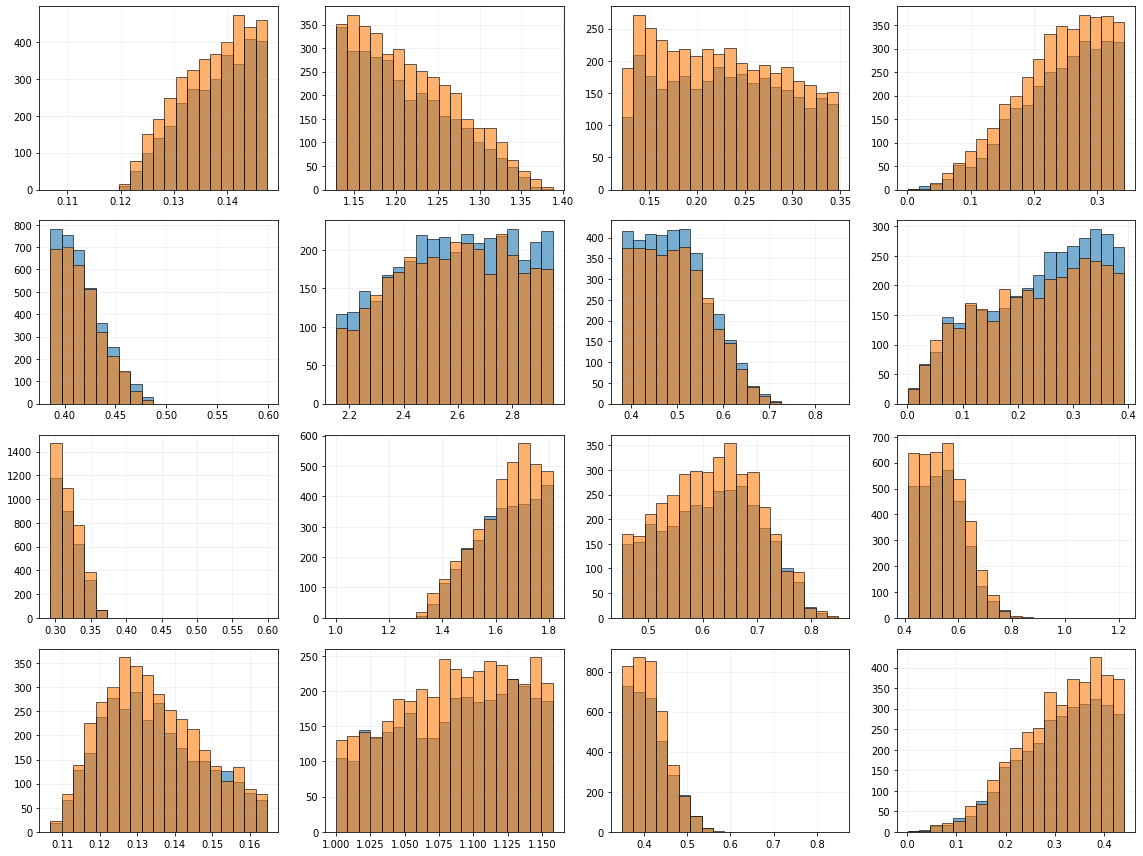

In [17]:
fig, axes = plot_k_worst_nodes(nodes, scores, k=4)

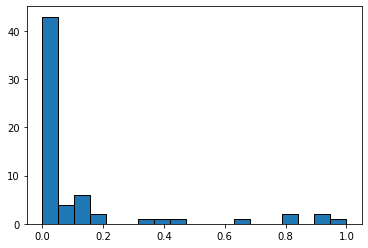

In [18]:
plt.hist(scores, edgecolor='k', bins=np.linspace(0,1,20));

In [19]:
worstnodes = get_k_worst_nodes(nodes, scores, k=10)

In [20]:
for j, wnode in enumerate(worstnodes):
    print(f'Worst node: {j}')
    minbound = wnode.bounds[0,:]
    maxbound = wnode.bounds[1,:]
    average = wnode.bounds.mean(axis=0)
    
    for i in range(len(minbound)):
        print(f'Axis {data_axes[i]} in range {minbound[i], maxbound[i]}, Avg. {average[i]}')

Worst node: 0
Axis x in range (0.10681463778018953, 0.1474788933992386), Avg. 0.12714676558971405
Axis q2 in range (1.128009796142578, 1.3876419067382812), Avg. 1.2578258514404297
Axis z in range (0.12129704654216765, 0.348224937915802), Avg. 0.23476099222898483
Axis pt in range (0.00048771032015793025, 0.3422793447971344), Avg. 0.17138352755864616
Worst node: 1
Axis x in range (0.3859523832798004, 0.5988612771034241), Avg. 0.49240683019161224
Axis q2 in range (2.1503634452819824, 2.9510953426361084), Avg. 2.5507293939590454
Axis z in range (0.3797449767589569, 0.8501449823379517), Avg. 0.6149449795484543
Axis pt in range (0.00048771032015793025, 0.3924458920955658), Avg. 0.19646680120786186
Worst node: 2
Axis x in range (0.2929314076900482, 0.5988612771034241), Avg. 0.44589634239673615
Axis q2 in range (1.0000007152557373, 1.814887762069702), Avg. 1.4074442386627197
Axis z in range (0.4510119557380676, 0.8501449823379517), Avg. 0.6505784690380096
Axis pt in range (0.4104576706886292, 

In [21]:
for j, wnode in enumerate(get_k_best_nodes(nodes, scores, k=10)):
    print(f'Best node: {j}')
    minbound = wnode.bounds[0,:]
    maxbound = wnode.bounds[1,:]
    average = wnode.bounds.mean(axis=0)

    for i in range(len(minbound)):
        print(f'Axis {data_axes[i]} in range {minbound[i], maxbound[i]}, Avg. {average[i]}')

Best node: 0
Axis x in range (0.2429497838020325, 0.32784515619277954), Avg. 0.285397469997406
Axis q2 in range (2.1503634452819824, 2.370410203933716), Avg. 2.260386824607849
Axis z in range (0.12129704654216765, 0.3797449767589569), Avg. 0.2505210116505623
Axis pt in range (0.3117729723453522, 1.2207576036453247), Avg. 0.7662652879953384
Best node: 1
Axis x in range (0.2429497838020325, 0.2818240821361542), Avg. 0.2623869329690933
Axis q2 in range (1.0000007152557373, 1.7930741310119631), Avg. 1.39653742313385
Axis z in range (0.12129704654216765, 0.4510119557380676), Avg. 0.28615450114011765
Axis pt in range (0.00048771032015793025, 0.3162972629070282), Avg. 0.15839248661359306
Best node: 2
Axis x in range (0.2429497838020325, 0.32784515619277954), Avg. 0.285397469997406
Axis q2 in range (2.370410203933716, 4.704831123352051), Avg. 3.5376206636428833
Axis z in range (0.12129704654216765, 0.3797449767589569), Avg. 0.2505210116505623
Axis pt in range (0.3117729723453522, 1.22075760364

In [22]:
bin_edges = worstnodes[1].bounds

In [23]:
subset1 = data.query(f'sector == 1 and q2 > {bin_edges[0,1]} and q2 < {bin_edges[1,1]} and z > {bin_edges[0,2]} and z < {bin_edges[1,2]} and pt > {bin_edges[0,3]} and pt < {bin_edges[1,3]}')
subset2 = data.query(f'sector == 2 and q2 > {bin_edges[0,1]} and q2 < {bin_edges[1,1]} and z > {bin_edges[0,2]} and z < {bin_edges[1,2]} and pt > {bin_edges[0,3]} and pt < {bin_edges[1,3]}')

In [24]:
len(subset1)

10343

In [25]:
len(subset2)

9631

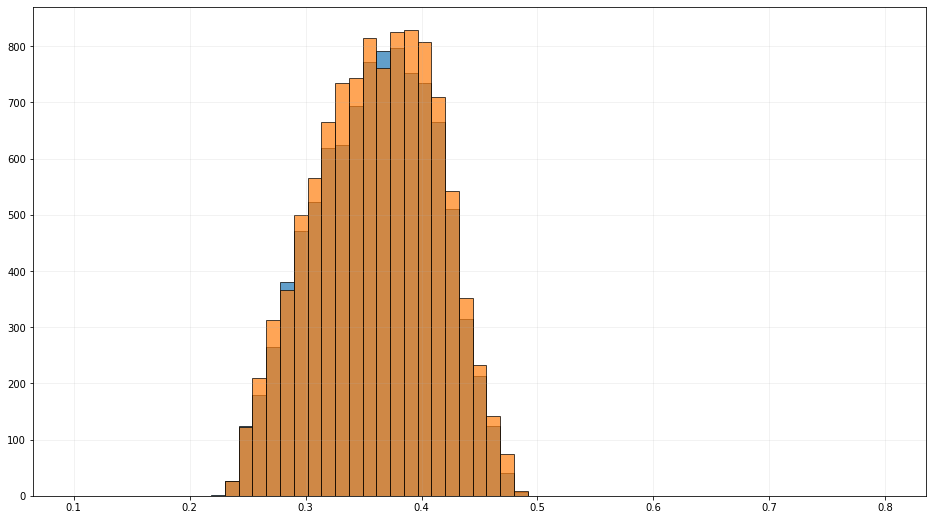

In [26]:
plt.figure(figsize=(16,9))
plt.hist(subset2['x'], edgecolor='k', alpha=0.7, bins=np.linspace(0.1, 0.8, 60));
plt.hist(subset1['x'], edgecolor='k', alpha=0.7, bins=np.linspace(0.1, 0.8, 60));
plt.grid(alpha=0.2)

In [27]:
def build_results_df(nodes, scores):
    d = {} 
    d['score'] = []
    for data_axis in data_axes:
        d[data_axis + '_min'] = [] 
        d[data_axis + '_max'] = [] 
        d[data_axis + '_avg'] = [] 

    for i, n in enumerate(nodes):
        d['score'].append(scores[i])
        
        for j, data_axis in enumerate(data_axes):
            d[data_axis + '_min'].append(n.bounds[0,j])
            d[data_axis + '_max'].append(n.bounds[1,j])
            d[data_axis + '_avg'].append(n.bounds.mean(axis=0)[j])
            
    return pd.DataFrame(d)

In [28]:
res = build_results_df(nodes, scores)

In [29]:
res.corr()['score']

score     1.000000
x_min     0.024387
x_max    -0.029049
x_avg    -0.011171
q2_min    0.056804
q2_max    0.008598
q2_avg    0.024286
z_min    -0.341266
z_max    -0.336791
z_avg    -0.341437
pt_min   -0.065644
pt_max   -0.030536
pt_avg   -0.041502
Name: score, dtype: float64

In [30]:
from sklearn.cluster import KMeans

In [31]:
cluster_axes = ['x_avg', 'q2_avg', 'z_avg', 'pt_avg', 'score'] 

In [32]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(res[cluster_axes])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [33]:
#res['cluster'] = kmeans.labels_
res['cluster'] = np.array(res['score'] > 0.5).astype(int)

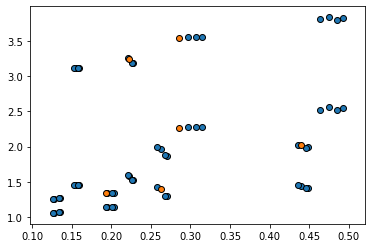

In [34]:
plt.scatter(res[res['cluster'] == 0]['x_avg'], res[res['cluster'] == 0]['q2_avg'], edgecolor='k');
plt.scatter(res[res['cluster'] == 1]['x_avg'], res[res['cluster'] == 1]['q2_avg'], edgecolor='k');

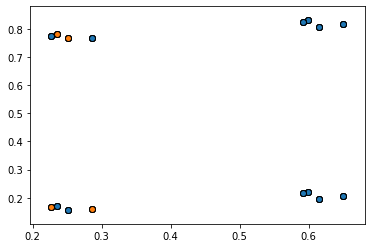

In [35]:
plt.scatter(res[res['cluster'] == 0]['z_avg'], res[res['cluster'] == 0]['pt_avg'], edgecolor='k');
plt.scatter(res[res['cluster'] == 1]['z_avg'], res[res['cluster'] == 1]['pt_avg'], edgecolor='k');

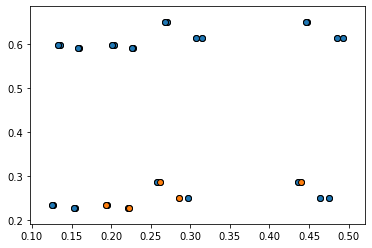

In [36]:
plt.scatter(res[res['cluster'] == 0]['x_avg'], res[res['cluster'] == 0]['z_avg'], edgecolor='k');
plt.scatter(res[res['cluster'] == 1]['x_avg'], res[res['cluster'] == 1]['z_avg'], edgecolor='k');